# MXNet Introduction and Tutorial

## Contents
0. [MXNet简介](#MXNet简介)
    0. [概况](#概况)
    0. [设计思想](#设计思想)
    0. [系统架构](#系统架构)
    0. [编程接口](#编程接口)
    0. [模型训练流程](#模型训练流程)
0. [MXNet Basic Tutorial: Hand Written Digit Recognition](#MXNet-Basic-Tutorial:-Hand-Written-Digit-Recognition)
    0. [Network Definition](#Network-Definition)
    0. [Variable Naming](#Variable-Naming)
    0. [Data Loading](#Data-Loading)
    0. [Model Training](#Model-Training)
    0. [Model Evaluation](#Model-Evaluation)
    0. [Model Debugging](#Model-Debugging)
    0. [Custom Training](#Custom-Training)
    0. [Create New Operators](#Create-New-Operators)
0. [MXNet Advanced Topic: Data Iterator and Bucketing](#MXNet-Advanced-Topic:-Data-Iterator-and-Bucketing)
    0. [Customized Data Iterator](#Customized-Data-Iterator)
    0. [Bucketing](#Bucketing)

## MXNet简介
0. [概况](#概况)
0. [设计思想](#设计思想)
0. [系统架构](#系统架构)
0. [编程接口](#编程接口)
0. [模型训练流程](#模型训练流程)

### 概况
 - 来自 Distributed (Deep) Machine Learning Community
 - 灵活性: 支持命令式（imprative）和符号式（symbolic） 编程
 - 可移植性：可运行在多种平台，包括集群、服务器、个人电脑、移动电话
 - 多语言接口：支持C++、python、R、Scale、Julia、Matlab、Javascript
 - 分布式计算：支持多机器，多GPU并行计算
 - 性能：目前已知最快

### 设计思想

#### 编程范式
0. 命令式编程
 - 命令“机器”如何去做事情(how)，这样不管你想要的是什么(what)，它都会按照你的命令实现。
 - 例子：numpy，matlab
0. 声明式编程
 - 告诉“机器”你想要的是什么(what)，让机器想出如何去做(how)。（caffe）
 - 例子：caffe

#### MXNet编程范式
0. 命令式编程
 - 张量运算：NDArray
 - 模型的迭代训练和更新模型法则中可能涉及大量的控制逻辑；方便地调试和与主语言交互数据。
0. 声明式编程
 - 符号表达式：Symbol
 - 描述神经网络，并利用系统提供的自动求导来训练模型。


|模型|浅嵌入，命令式编程|深嵌入，声明式编程|
|------|---------------------------|---------------------------|
|如何执行a=b+1|需要b已经被赋值。立即执行加法，将结果保存在a中。|返回对应的计算图(computation graph)，我们可以之后对b进行赋值，然后再执行加法运算|
|优点 |语义上容易理解，灵活，可以精确控制行为。通常可以无缝的和主语言交互，方便的利用主语言的各类算法，工具包，bug和性能调试器。|在真正开始计算的时候已经拿到了整个计算图，所以我们可以做一系列优化来提升性能。实现辅助函数也容易，例如对任何计算图都提供forward和backward函数，对计算图进行可视化，将图保存到硬盘和从硬盘读取。|
|缺点|实现统一的辅助函数困和提供整体优化都很困难。|很多主语言的特性都用不上。某些在主语言中实现简单，但在这里却经常麻烦，例如if-else语句 。debug也不容易，例如监视一个复杂的计算图中的某个节点的中间结果并不简单。|

#### 深度学习系统比较

|系统|主语言|从语言|硬件|分布式|命令式|声明式|
|------|---------|---------|------|---------|---------|---------|
|Caffe|C++|Python/Matlab|CPU/GPU|x|x|v|
|Torch|Lua|-|CPU/GPU/FPGA|x|v|x|
|Theano|Python|-|CPU/GPU|x|x|v|
|TensorFlow|C++|Python|CPU/GPU/Mobile|v|x|v|
|MXNet|C++|Python/R/Julia/Go|CPU/GPU/Mobile|v|v|v|

### 系统架构
<img src="https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/paper/sys.png" width="400" height="400"/>
从上到下分别为:
 - 各种主语言的嵌入
 - 编程接口（矩阵运算，符号表达式，分布式通讯）
 - 两种编程模式的统一系统实现
 - 各硬件的支持。

### 编程接口

#### Symbol：声明式的符号表达式
0. MXNet使用多值输出的符号表达式来声明计算图。符号是由操作子构建而来。
0. 一个操作子可以是一个简单的矩阵运算“+”，也可以是一个复杂的神经网络里面的层，例如卷积层。
0. 一个操作子可以有多个输入变量和多个输出变量，还可以有内部状态变量。
0. 在执行一个符号表达式前，我们需要对所有的自由变量进行赋值。例如给定数据，和各个层里隐式定义的输入（权重和偏值）

代码示例：定义一个多层感知器网络
```Python
data = mx.symbol.Variable('data')
label = mx.symbol.Variable('softmax_label')
fc1 = mx.symbol.FullyConnected(data = data, name = 'fc1', num_hidden = 128)
act1 = mx.symbol.Activation(data = fc1, name = 'relu1', act_type = 'relu')
fc2 = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
act2 = mx.symbol.Activation(data = fc2, name = 'relu2', act_type = 'relu')
fc3 = mx.symbol.FullyConnected(data = act2, name = 'fc3', num_hidden = 10)
mlp = mx.symbol.SoftmaxOutput(data = fc3, label = label, name = 'softmax')
```

#### NDArray：命令式的张量计算
0. MXNet提供命令式的张量计算来桥接主语言的和符号表达式。
0. 基本语法类似于numpy。
0. NDArray可以无缝和符号表达式进行对接。

代码示例：基本变量定义和梯度下降算法
```Python
a = mx.nd.zeros((100, 50))
a[0:10] = 1
gpu_a = mx.nd.zeros((100, 50), mx.Context(mx.gpu(0)))
print a.shape
print a.asnumpy()
b = mx.nd.array([[1, 2, 3], [4, 5, 6]])

# Parameter Update
for (int i = 0; i < max_iter; ++i) {
  network.forward();
  network.backward();
  network.weight -= eta * network.gradient
}
```

#### KVStore：多设备间的数据交互
0. push： 将key-value对从一个设备push进存储。
0. pull：将某个key上的值从存储中pull出来。
0. KVStore还接受自定义的更新函数来控制收到的值如何写入到存储中。
0. KVStore提供数种包含最终一致性模型和顺序一致性模型在内的数据一致性模型。

```Python
KVStore kvstore("dist_async");
kvstore.set_updater([](NDArray weight, NDArray gradient) {
    weight -= eta * gradient;
  });
for (int i = 0; i < max_iter; ++i) {
   kvstore.pull(network.weight);
   network.forward();
   network.backward();
   kvstore.push(network.gradient);
}
```


#### Model：训练模块
0. MXNet实现了常用的优化算法来训练模型。
0. 用户只需要提供数据数据迭代器和神经网络的Symbol。
0. 用户可以提供额外的KVStore来进行分布式的训练。

代码示例：使用SGD来训练一个模型。
```Python
model = mx.model.FeedForward(
    ctx                = mx.gpu(0),
    symbol             = network,
    num_epoch          = 100,
    optimizer          = 'sgd',
    learning_rate      = 0.01,
    momentum           = 0.9,
    wd                 = 0.00001,
    initializer        = mx.init.Xavier(factor_type="in", magnitude=2.34)
)
model.fit(
    X                  = train_iter,
    eval_data          = val_iter,
    eval_metric        = 'acc',
    batch_end_callback = [mx.callback.Speedometer(batch_size, frequent = 100)],
    epoch_end_callback = [mx.callback.do_checkpoint('model_')]
)
```

#### 其他模块
0. IO：定义数据迭代器，如NDArrayIter等
0. Metric：定义评测标准，如accuracy，F1-Score, CrossEntropy等
0. Initializer：定义初始化方法，如Uniform，Normal，orthogonal等
0. Optimizer：定义优化方法，如SGD，Adam，AdaGrad等

### 模型训练流程
 - 定义网络结构：mx.symbol.FullyConnected(), mx.symbol.Convolution()
 - 定义数据迭代器：mx.io.DataIter
 - 初始化参数：mx.initializer.Uniform(), mx.initializer.Orthogonal(), mx.initializer.Normal()
 - 确定优化方法：mx.optimizer.SGD(), mx.optimizer.Adam()
 - 确定评价标准：mx.metric.Accuracy, mx.metric.CrossEntropy()
 - 训练模型;mx.model.FeedForward(), model.fit()

## MXNet Basic Tutorial: Hand Written Digit Recognition
0. [Network Definition](#Network-Definition)
0. [Variable Naming](#Variable-Naming)
0. [Data Loading](#Data-Loading)
0. [Model Training](#Model-Training)
0. [Model Evaluation](#Model-Evaluation)
0. [Model Debugging](#Model-Debugging)
0. [Custom Training](#Custom-Training)
0. [Create New Operators](#Create-New-Operators)

First let's import the modules and setup logging:

In [1]:
%matplotlib inline
import mxnet as mx
import numpy as np
import cv2
import matplotlib.pyplot as plt
import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

### Network Definition
Now we can start constructing our network:

In [2]:
# Variables are place holders for input arrays. We give each variable a unique name.
data = mx.symbol.Variable('data')

fc1  = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")

fc2  = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")

fc3  = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=10)
# Finally we have a loss layer that compares the network's output with label and generates gradient signals.
# mxnet has no specific loss class, the last(output) layer also determines the loss function
# the last layer in the network is always the symbol end with 'Output' 
mlp  = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

We can visualize the network we just defined with MXNet's visualization module:

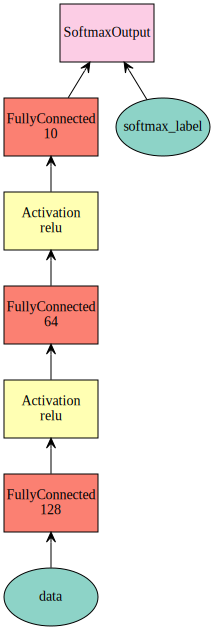

In [3]:
mx.viz.plot_network(mlp)

### Variable Naming

MXNet requires variable names to follow certain conventions:
- All input arrays have a name. This includes inputs (data & label) and model parameters (weight, bias, etc).
- Arrays can be renamed by creating named variable. Otherwise, a default name is given as 'SymbolName_ArrayName'. For example, FullyConnected symbol fc1's weight array is named as 'fc1_weight'.
- Although you can also rename weight arrays with variables, weight array's name should always end with '_weight' and bias array '_bias'. MXNet relies on the suffixes of array names to correctly initialize & update them.

Call list_arguments method on a symbol to get the names of all its inputs:

In [4]:
mlp.list_arguments()

['data',
 'fc1_weight',
 'fc1_bias',
 'fc2_weight',
 'fc2_bias',
 'fc3_weight',
 'fc3_bias',
 'softmax_label']

### Data Loading

We fetch and load the MNIST dataset and partition it into two sets: 60000 examples for training and 10000 examples for testing. We also visualize a few examples to get an idea of what the dataset looks like.

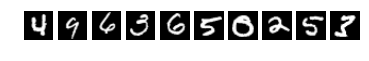

In [5]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
np.random.seed(1234) # set seed for deterministic ordering
p = np.random.permutation(mnist.data.shape[0])
X = mnist.data[p]
Y = mnist.target[p]

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(X[i].reshape((28,28)), cmap='Greys_r')
    plt.axis('off')
plt.show()

X = X.astype(np.float32)/255
X_train = X[:60000]
X_test = X[60000:]
Y_train = Y[:60000]
Y_test = Y[60000:]

Now we can create data iterators from our MNIST data. A data iterator returns a batch of data examples each time for the network to process. MXNet provide a suite of basic DataIters for parsing different data format. Here we use NDArrayIter, which wraps around a numpy array and each time slice a chunk from it along the first dimension.

In [6]:
batch_size = 100
train_iter = mx.io.NDArrayIter(X_train, Y_train, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(X_test, Y_test, batch_size=batch_size)

### Model Training

With the network and data source defined, we can finally start to train our model. We do this with MXNet's convenience wrapper for feed forward neural networks (it can also be made to handle RNNs with explicit unrolling). 

In [8]:
model = mx.model.FeedForward(
    ctx = mx.gpu(0),         # Run on GPU 0
    symbol = mlp,            # Use the network we just defined
    num_epoch = 10,          # Train for 10 epochs
    optimizer = 'sgd',       # optimize using SGD
    initializer = mx.init.Uniform(0.01), # initilize using uniform
    learning_rate = 0.1,     # Learning rate
    momentum = 0.9,          # Momentum for SGD with momentum
    wd = 0.00001             # Weight decay for regularization
)
model.fit(
    X=train_iter,  # Training data set
    eval_data=test_iter,  # Testing data set. MXNet computes scores on test set every epoch
    batch_end_callback = mx.callback.Speedometer(batch_size, 200)  # Logging module to print out progress
)

### Model Evaluation

After the model is trained, we can evaluate it on a held out test set.
First, lets classity a sample image:

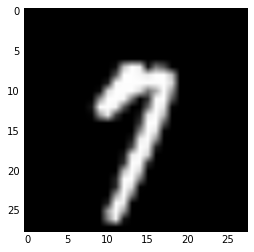

Result: 7


In [9]:
plt.imshow((X_test[0].reshape((28,28))*255).astype(np.uint8), cmap='Greys_r')
plt.show()
print 'Result:', model.predict(X_test[0:1])[0].argmax()

We can also evaluate the model's accuracy on the entire test set:

In [10]:
print 'Accuracy:', model.score(test_iter)*100, '%'

Accuracy: 97.65 %


Now, try if your model recognizes your own hand writing.

Write a digit from 0 to 9 in the box below. Try to put your digit in the middle of the box.

### Model Debugging

DNNs can perform poorly for a lot of reasons, like learning rate too big/small, initialization too big/small, network structure not reasonable, etc. When this happens it's often helpful to print out the weights and intermediate outputs to understand what's going on. MXNet provides a monitor utility that does this:

In [11]:
def norm_stat(d):
    """The statistics you want to see.
    We compute the L2 norm here but you can change it to anything you like."""
    return mx.nd.norm(d)/np.sqrt(d.size)
mon = mx.mon.Monitor(
    100,                 # Print every 100 batches
    norm_stat,           # The statistics function defined above
    pattern='.*weight',  # A regular expression. Only arrays with name matching this pattern will be included.
    sort=True)           # Sort output by name
model = mx.model.FeedForward(ctx = mx.gpu(0), symbol = mlp, num_epoch = 1,
                             learning_rate = 0.1, momentum = 0.9, wd = 0.00001)
model.fit(X=train_iter, eval_data=test_iter, monitor=mon,  # Set the monitor here
          batch_end_callback = mx.callback.Speedometer(100, 100))

### Custom Training

`mx.model.FeedForward` is a convenience wrapper for training standard feed forward networks. What if the model you are working with is more complicated? With MXNet, you can easily control every aspect of training by writing your own training loop.

Neural network training typically has 3 steps: forward, backward (gradient), and update. With custom training loop, you can control the details in each step as while as insert complicated computations in between. You can also connect multiple networks together.

In [12]:
# ==================Binding=====================
# The symbol we created is only a graph description.
# To run it, we first need to allocate memory and create an executor by 'binding' it.
# In order to bind a symbol, we need at least two pieces of information: context and input shapes.
# Context specifies which device the executor runs on, e.g. cpu, GPU0, GPU1, etc.
# Input shapes define the executor's input array dimensions.
# MXNet then run automatic shape inference to determine the dimensions of intermediate and output arrays.

# data iterators defines shapes of its output with provide_data and provide_label property.
input_shapes = dict(train_iter.provide_data+train_iter.provide_label)
print 'input_shapes', input_shapes
# We use simple_bind to let MXNet allocate memory for us.
# You can also allocate memory youself and use bind to pass it to MXNet.
exe = mlp.simple_bind(ctx=mx.gpu(0), **input_shapes)

# ===============Initialization=================
# First we get handle to input arrays
arg_arrays = dict(zip(mlp.list_arguments(), exe.arg_arrays))
data = arg_arrays[train_iter.provide_data[0][0]]
label = arg_arrays[train_iter.provide_label[0][0]]

# We initialize the weights with uniform distribution on (-0.01, 0.01).
init = mx.init.Uniform(scale=0.01)
for name, arr in arg_arrays.items():
    if name not in input_shapes:
        init(name, arr)
    
# We also need to create an optimizer for updating weights
opt = mx.optimizer.SGD(
    learning_rate=0.1,
    momentum=0.9,
    wd=0.00001,
    rescale_grad=1.0/train_iter.batch_size)
updater = mx.optimizer.get_updater(opt)

# Finally we need a metric to print out training progress
metric = mx.metric.Accuracy()

# Training loop begines
for epoch in range(10):
    train_iter.reset()
    metric.reset()
    t = 0
    for batch in train_iter:
        # Copy data to executor input. Note the [:].
        data[:] = batch.data[0]
        label[:] = batch.label[0]
        
        # Forward
        exe.forward(is_train=True)
        
        # You perform operations on exe.outputs here if you need to.
        # For example, you can stack a CRF on top of a neural network.
        
        # Backward
        exe.backward()
        
        # Update
        for i, pair in enumerate(zip(exe.arg_arrays, exe.grad_arrays)):
            weight, grad = pair
            updater(i, grad, weight)
        metric.update(batch.label, exe.outputs)
        t += 1
        if t % 100 == 0:
            print 'epoch:', epoch, 'iter:', t, 'metric:', metric.get()


input_shapes {'softmax_label': (100,), 'data': (100, 784L)}
epoch: 0 iter: 100 metric: ('accuracy', 0.1427)
epoch: 0 iter: 200 metric: ('accuracy', 0.42695)
epoch: 0 iter: 300 metric: ('accuracy', 0.5826333333333333)
epoch: 0 iter: 400 metric: ('accuracy', 0.66875)
epoch: 0 iter: 500 metric: ('accuracy', 0.72238)
epoch: 0 iter: 600 metric: ('accuracy', 0.7602166666666667)
epoch: 1 iter: 100 metric: ('accuracy', 0.9504)
epoch: 1 iter: 200 metric: ('accuracy', 0.9515)
epoch: 1 iter: 300 metric: ('accuracy', 0.9547666666666667)
epoch: 1 iter: 400 metric: ('accuracy', 0.956475)
epoch: 1 iter: 500 metric: ('accuracy', 0.95762)
epoch: 1 iter: 600 metric: ('accuracy', 0.9591666666666666)
epoch: 2 iter: 100 metric: ('accuracy', 0.9681)
epoch: 2 iter: 200 metric: ('accuracy', 0.9699)
epoch: 2 iter: 300 metric: ('accuracy', 0.9718666666666667)
epoch: 2 iter: 400 metric: ('accuracy', 0.97205)
epoch: 2 iter: 500 metric: ('accuracy', 0.97282)
epoch: 2 iter: 600 metric: ('accuracy', 0.97288333333333

### Create New Operators

MXNet provides a repository of common operators (or layers). However, new models often require new layers. There are several ways to [create new operators](https://mxnet.readthedocs.org/en/latest/tutorial/new_op_howto.html) with MXNet. Here we talk about the easiest way: pure python. 

In [13]:
# Define custom softmax operator
class NumpySoftmax(mx.operator.NumpyOp):
    def __init__(self):
        # Call the parent class constructor. 
        # Because NumpySoftmax is a loss layer, it doesn't need gradient input from layers above.
        super(NumpySoftmax, self).__init__(need_top_grad=False)
    
    def list_arguments(self):
        # Define the input to NumpySoftmax.
        return ['data', 'label']

    def list_outputs(self):
        # Define the output.
        return ['output']

    def infer_shape(self, in_shape):
        # Calculate the dimensions of the output (and missing inputs) from (some) input shapes.
        data_shape = in_shape[0]  # shape of first argument 'data'
        label_shape = (in_shape[0][0],)  # 'label' should be one dimensional and has batch_size instances.
        output_shape = in_shape[0] # 'output' dimension is the same as the input.
        return [data_shape, label_shape], [output_shape]

    def forward(self, in_data, out_data):
        x = in_data[0]  # 'data'
        y = out_data[0]  # 'output'
        
        # Compute softmax
        y[:] = np.exp(x - x.max(axis=1).reshape((x.shape[0], 1)))
        y /= y.sum(axis=1).reshape((x.shape[0], 1))

    def backward(self, out_grad, in_data, out_data, in_grad):
        l = in_data[1]  # 'label'
        l = l.reshape((l.size,)).astype(np.int)  # cast to int
        y = out_data[0]  # 'output'
        dx = in_grad[0]  # gradient for 'data'
        
        # Compute gradient
        dx[:] = y
        dx[np.arange(l.shape[0]), l] -= 1.0

numpy_softmax = NumpySoftmax()

data = mx.symbol.Variable('data')
fc1 = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
fc2 = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
fc3 = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=10)
# Use the new operator we just defined instead of the standard softmax operator.
mlp = numpy_softmax(data=fc3, name = 'softmax')

model = mx.model.FeedForward(ctx = mx.gpu(0), symbol = mlp, num_epoch = 2,
                             learning_rate = 0.1, momentum = 0.9, wd = 0.00001)
model.fit(X=train_iter, eval_data=test_iter,
          batch_end_callback = mx.callback.Speedometer(100, 100))

## MXNet Advanced Topic: Data Iterator and Bucketing

### Customized Data Iterator
```Python
class SimpleBatch(object):
	def __init__(self, data, label):
    @property
    def provide_data(self):
		return [('data_name1' , data1),
                ('data_name2' , data2)]
                
    @property
    def provide_label(self):
		return [('label_name', label1)]

class SequenceIter(mx.io.DataIter):
	def __init__(self, data, label):
		super(SequenceIter, self).__init__() 
     
    @property
    def provide_data(self):
		return [('data_name1' , data_shape1),
                ('data_name2' , data_shape2)]
                
    @property
    def provide_label(self):
		return [('label_name', label_shape)]

	def __iter__(self):
        while (condition):
            data_batch = SimpleBatch(data, label)
			yield data_batch
            
	def reset(self):
		self.reset_iterator	

```

### Bucketing
0. RNN Implementation
 - Always Explicitly Unroll the RNN: Need to know length at advance
 - Always use the maximum possible sequence length: Computation Waste
<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="800" height="400"/>

0. Bucketing
 - Unroll multiple instances of different lengths (e.g., length 5, 10, 20, 30)
 - Choose the most appropriate unrolled model for each mini-batch of data with different sequence length.
 - Share the parameters for different instance.


Use Details

- Constructe a model with a function that generates a new Symbol on a bucket key instead of a fixed Symbol
 
```Python
def sym_gen(seq_len):
    return lstm_unroll(num_lstm_layer, seq_len, len(vocab),
                       num_hidden=num_hidden, num_embed=num_embed,
                       num_label=len(vocab)
           )
model = mx.model.FeedForward(
        ctx     = contexts,
        symbol  = sym_gen
)
```

 - Provide additional attributes in Data Iterator

```Python
class SimpleBatch(object):
	def __init__(self, data, label):
    @property
    def bucket_key(self):
		return bucket_key
                

class SequenceIter(mx.io.DataIter):     
    @property
    def default_bucket_key(self):
		return default_bucket_key
```
 - Beyond Sequence Training: bucket key can be an arbitrary object, tuple for seq2seq network